# Whale Audio Classification using Spectrograms and Deep Learning (PyTorch)

This notebook provides a complete pipeline for classifying whale and marine species sounds using:
- **Scipy Spectrograms** for audio representation
- **CNN**, **LSTM**, and **Transformer** models with **PyTorch**

## Dataset Structure
- Audio files in: `wmms_audio/` folder
- Labels in: `wmms_labels.csv` file

## 1. Install and Import Libraries

In [ ]:
# Install required libraries (run once)
!pip install torch torchvision scipy scikit-learn matplotlib pandas numpy soundfile tqdm seaborn --quiet

In [11]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from scipy import signal
from scipy.io import wavfile
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
import warnings
import math
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.6.0+cu124
Device: cuda
GPU: NVIDIA RTX A6000


In [5]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


## 2. Configuration

In [13]:
# Dataset paths
AUDIO_DIR = 'wmms_audio'
LABELS_CSV = 'wmms_labels.csv'

# Audio processing parameters
SAMPLE_RATE = 22050      # Target sample rate
DURATION = 5             # Audio duration in seconds
N_FFT = 2048             # FFT window size (nperseg for scipy)
HOP_LENGTH = 512         # Hop length (noverlap = N_FFT - HOP_LENGTH)
N_FREQ_BINS = 128        # Number of frequency bins to use

# Training parameters
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2
TEST_SIZE = 0.2

print("Configuration set successfully!")

Configuration set successfully!


## 3. Data Exploration

In [16]:
# Load labels CSV
df = pd.read_csv(LABELS_CSV)

print(f"CSV Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print("\nFirst 10 rows:")
display(df.head(10))

CSV Shape: (1357, 4)

Columns: ['file', 'species', 'label_id', 'duration_sec']

First 10 rows:


,file,species,label_id,duration_sec
0,clip_00000.wav,Spinner_Dolphin,26,NaN
1,clip_00001.wav,Bearded_Seal,1,NaN
2,clip_00002.wav,Weddell_Seal,29,NaN
3,clip_00003.wav,Harp_Seal,11,NaN
4,clip_00004.wav,False_Killer_Whale,7,NaN
5,clip_00005.wav,Frasers_Dolphin,9,NaN
6,clip_00006.wav,Long-Finned_Pilot_Whale,15,NaN
7,clip_00007.wav,"Beluga,_White_Whale",2,NaN
8,clip_00008.wav,Atlantic_Spotted_Dolphin,0,NaN
9,clip_00009.wav,Spinner_Dolphin,26,NaN


In [18]:
# Identify filename and label columns
print("Available columns:")
for i, col in enumerate(df.columns):
    print(f"  {i}: {col}")

# Auto-detect columns (adjust if needed)
filename_col = 'file' if 'file' in df.columns else df.columns[0]
label_col = 'species' if 'species' in df.columns else df.columns[1]

print(f"\nUsing '{filename_col}' as filename column")
print(f"Using '{label_col}' as label column")

Available columns:
  0: file
  1: species
  2: label_id
  3: duration_sec

Using 'file' as filename column
Using 'species' as label column



Number of classes: 32

Class distribution:
species
Spinner_Dolphin                     91
Frasers_Dolphin                     69
Striped_Dolphin                     65
Sperm_Whale                         60
Long-Finned_Pilot_Whale             56
Grampus,_Rissos_Dolphin             54
Pantropical_Spotted_Dolphin         53
Short-Finned_Pacific_Pilot_Whale    53
Humpback_Whale                      51
Clymene_Dolphin                     50
Melon_Headed_Whale                  50
Bowhead_Whale                       48
False_Killer_Whale                  47
White-beaked_Dolphin                46
Atlantic_Spotted_Dolphin            46
White-sided_Dolphin                 44
Northern_Right_Whale                43
Common_Dolphin                      42
Rough-Toothed_Dolphin               40
Fin,_Finback_Whale                  40
Beluga,_White_Whale                 40
Narwhal                             40
Ross_Seal                           40
Harp_Seal                           38
Bearded_Seal

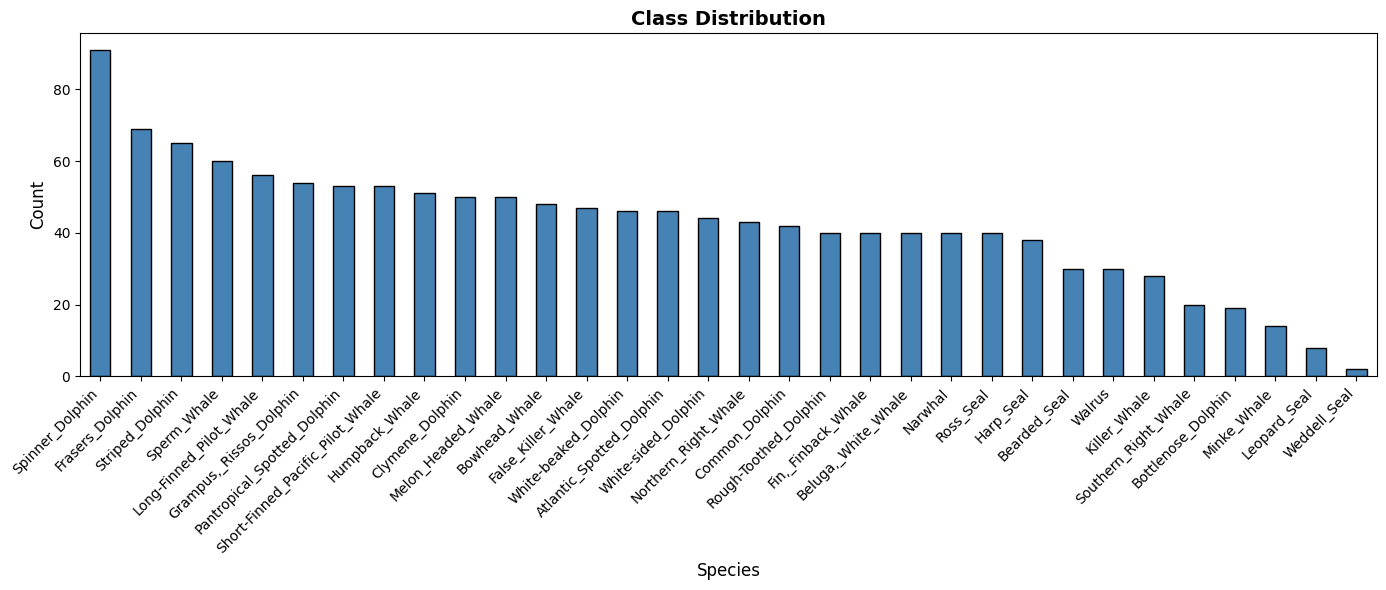


Min samples per class: 2
Max samples per class: 91
Imbalance ratio: 45.50


In [20]:
# Class distribution
class_counts = df[label_col].value_counts()
print(f"\nNumber of classes: {len(class_counts)}")
print(f"\nClass distribution:")
print(class_counts)

# Plot class distribution
plt.figure(figsize=(14, 6))
class_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Species', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Check class imbalance
min_samples = class_counts.min()
max_samples = class_counts.max()
imbalance_ratio = max_samples / min_samples

print(f"\nMin samples per class: {min_samples}")
print(f"Max samples per class: {max_samples}")
print(f"Imbalance ratio: {imbalance_ratio:.2f}")

## 4. Audio Processing Functions (Using Scipy Spectrogram)

In [23]:
def load_audio(audio_path, target_sr=SAMPLE_RATE, duration=DURATION):
    """
    Load audio file and resample if necessary
    
    Args:
        audio_path: Path to audio file
        target_sr: Target sample rate
        duration: Duration in seconds
        
    Returns:
        audio: Audio signal as numpy array
        sr: Sample rate
    """
    try:
        # Load audio using soundfile
        audio, sr = sf.read(audio_path)
        
        # Convert stereo to mono if needed
        if len(audio.shape) > 1:
            audio = np.mean(audio, axis=1)
        
        # Resample if necessary
        if sr != target_sr:
            # Calculate number of samples for target sample rate
            num_samples = int(len(audio) * target_sr / sr)
            audio = signal.resample(audio, num_samples)
            sr = target_sr
        
        # Pad or trim to fixed length
        target_length = target_sr * duration
        if len(audio) < target_length:
            audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
        else:
            audio = audio[:target_length]
        
        return audio, sr
        
    except Exception as e:
        print(f"Error loading {audio_path}: {str(e)}")
        return None, None


def audio_to_spectrogram(audio_path, sample_rate=SAMPLE_RATE, duration=DURATION,
                         n_fft=N_FFT, hop_length=HOP_LENGTH, n_freq_bins=N_FREQ_BINS):
    """
    Convert audio file to spectrogram using scipy.signal.spectrogram
    
    Args:
        audio_path: Path to audio file
        sample_rate: Target sample rate
        duration: Audio duration in seconds
        n_fft: FFT window size
        hop_length: Hop length between windows
        n_freq_bins: Number of frequency bins to keep
        
    Returns:
        Normalized spectrogram as numpy array
    """
    try:
        # Load audio
        audio, sr = load_audio(audio_path, sample_rate, duration)
        
        if audio is None:
            return None
        
        # Calculate noverlap from hop_length
        noverlap = n_fft - hop_length
        
        # Compute spectrogram using scipy
        frequencies, times, Sxx = signal.spectrogram(
            audio,
            fs=sr,
            window='hann',
            nperseg=n_fft,
            noverlap=noverlap,
            nfft=n_fft,
            scaling='density',
            mode='magnitude'
        )
        
        # Keep only the first n_freq_bins frequency bins
        Sxx = Sxx[:n_freq_bins, :]
        
        # Convert to log scale (dB) - add small epsilon to avoid log(0)
        Sxx_db = 10 * np.log10(Sxx + 1e-10)
        
        # Normalize to [0, 1]
        Sxx_norm = (Sxx_db - Sxx_db.min()) / (Sxx_db.max() - Sxx_db.min() + 1e-8)
        
        return Sxx_norm
        
    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return None

print("Audio processing functions defined (using scipy spectrogram)!")

Audio processing functions defined (using scipy spectrogram)!


## 5. Visualize Sample Audio

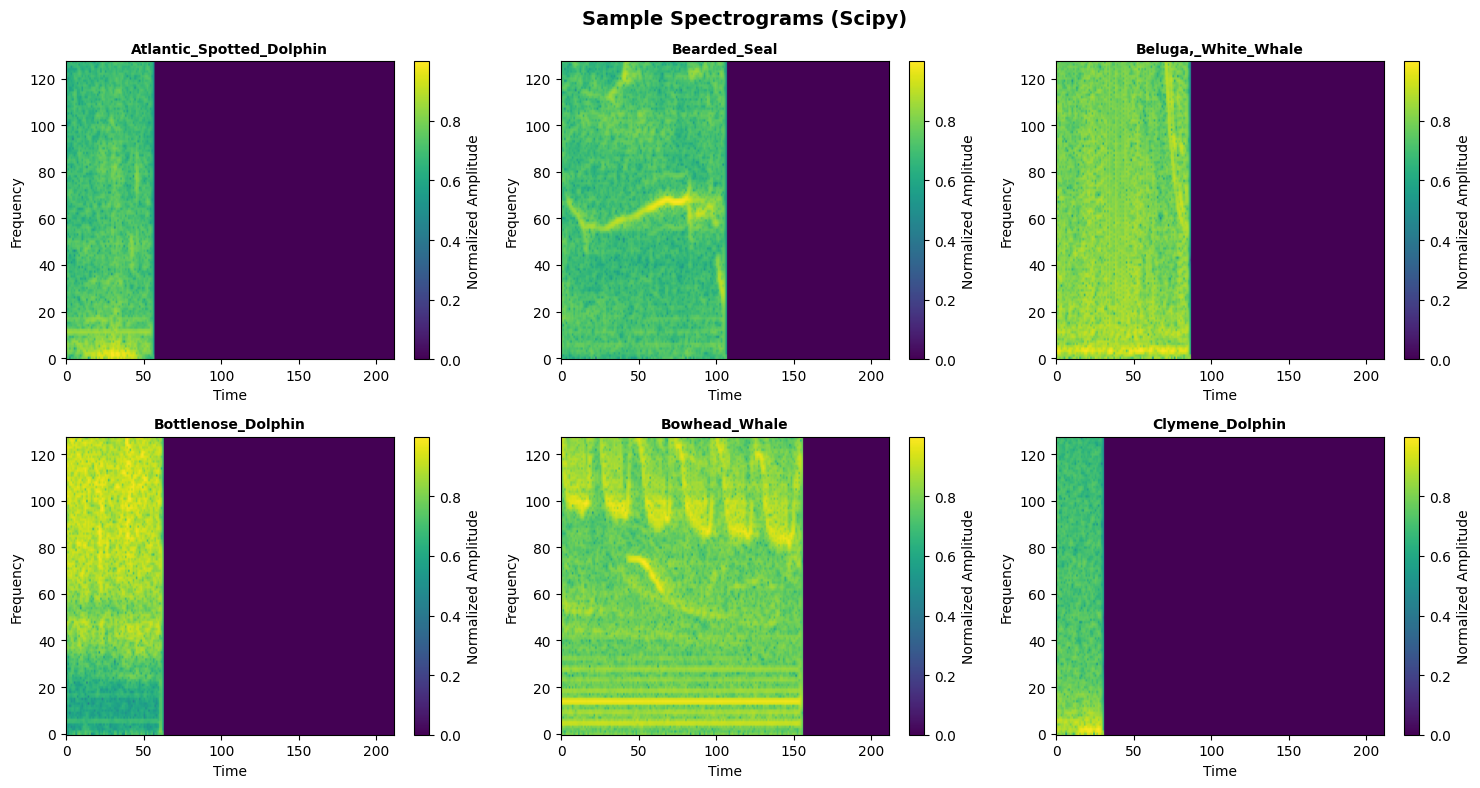

In [26]:
# Get sample files for visualization
sample_files = df.groupby(label_col).first().reset_index()
num_samples = min(6, len(sample_files))

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, (idx, row) in enumerate(sample_files.head(num_samples).iterrows()):
    filename = row[filename_col]
    label = row[label_col]
    audio_path = os.path.join(AUDIO_DIR, filename)
    
    if os.path.exists(audio_path):
        spec = audio_to_spectrogram(audio_path)
        if spec is not None:
            im = axes[i].imshow(spec, aspect='auto', origin='lower', cmap='viridis')
            axes[i].set_title(f'{label}', fontsize=10, fontweight='bold')
            axes[i].set_xlabel('Time')
            axes[i].set_ylabel('Frequency')
            plt.colorbar(im, ax=axes[i], label='Normalized Amplitude')

plt.suptitle('Sample Spectrograms (Scipy)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Prepare Dataset

In [29]:
# Load all audio files and convert to spectrograms
print("Loading and processing audio files...")
print("This may take a few minutes depending on dataset size.\n")

X = []
y = []
failed_files = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing audio"):
    filename = row[filename_col]
    label = row[label_col]
    
    # Try to find the audio file
    audio_path = os.path.join(AUDIO_DIR, filename)
    
    if not os.path.exists(audio_path):
        # Try different extensions
        for ext in ['.wav', '.mp3', '.flac', '.ogg']:
            base_name = os.path.splitext(filename)[0]
            audio_path = os.path.join(AUDIO_DIR, base_name + ext)
            if os.path.exists(audio_path):
                break
    
    if not os.path.exists(audio_path):
        failed_files.append(filename)
        continue
    
    # Convert to spectrogram
    spec = audio_to_spectrogram(audio_path)
    
    if spec is not None:
        X.append(spec)
        y.append(label)

if failed_files:
    print(f"\n Warning: Could not find {len(failed_files)} audio files")

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Add channel dimension for CNN (batch, channel, height, width)
X = X[:, np.newaxis, :, :]  # PyTorch expects (N, C, H, W)

print(f"\n{'='*60}")
print("Data Preparation Complete!")
print(f"{'='*60}")
print(f"Total samples loaded: {len(X)}")
print(f"Spectrogram shape: {X.shape}")
print(f"Input shape per sample: {X.shape[1:]}")

Loading and processing audio files...
This may take a few minutes depending on dataset size.



Processing audio: 100%|████████████████████████████████████████████████████████████| 1357/1357 [01:33<00:00, 14.46it/s]


Data Preparation Complete!
Total samples loaded: 1357
Spectrogram shape: (1357, 1, 128, 212)
Input shape per sample: (1, 128, 212)


In [9]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Classes: {label_encoder.classes_}")

Number of classes: 32
Classes: ['Atlantic_Spotted_Dolphin' 'Bearded_Seal' 'Beluga,_White_Whale'
 'Bottlenose_Dolphin' 'Bowhead_Whale' 'Clymene_Dolphin' 'Common_Dolphin'
 'False_Killer_Whale' 'Fin,_Finback_Whale' 'Frasers_Dolphin'
 'Grampus,_Rissos_Dolphin' 'Harp_Seal' 'Humpback_Whale' 'Killer_Whale'
 'Leopard_Seal' 'Long-Finned_Pilot_Whale' 'Melon_Headed_Whale'
 'Minke_Whale' 'Narwhal' 'Northern_Right_Whale'
 'Pantropical_Spotted_Dolphin' 'Ross_Seal' 'Rough-Toothed_Dolphin'
 'Short-Finned_Pacific_Pilot_Whale' 'Southern_Right_Whale' 'Sperm_Whale'
 'Spinner_Dolphin' 'Striped_Dolphin' 'Walrus' 'Weddell_Seal'
 'White-beaked_Dolphin' 'White-sided_Dolphin']


## 7. Split Data

In [10]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=TEST_SIZE, 
    random_state=42, 
    stratify=y_encoded
)

# Further split train into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=VALIDATION_SPLIT,
    random_state=42,
    stratify=y_train
)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nTraining data shape: {X_train.shape}")

Training set: 868 samples
Validation set: 217 samples
Test set: 272 samples

Training data shape: (868, 1, 128, 212)


## 8. Create PyTorch Datasets and DataLoaders

In [11]:
class WhaleAudioDataset(Dataset):
    """Custom Dataset for whale audio spectrograms"""
    
    def __init__(self, X, y, transform=None):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y

# Create datasets
train_dataset = WhaleAudioDataset(X_train, y_train)
val_dataset = WhaleAudioDataset(X_val, y_val)
test_dataset = WhaleAudioDataset(X_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 28
Validation batches: 7
Test batches: 9


## 9. Model Definitions

### 9.1 CNN Model

In [12]:
class WhaleCNN(nn.Module):
    """CNN model for whale audio classification"""
    
    def __init__(self, num_classes, input_height=N_FREQ_BINS, input_width=None):
        super(WhaleCNN, self).__init__()
        
        # First Convolutional Block
        self.conv1a = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1a = nn.BatchNorm2d(32)
        self.conv1b = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn1b = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        
        # Second Convolutional Block
        self.conv2a = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2a = nn.BatchNorm2d(64)
        self.conv2b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2b = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)
        
        # Third Convolutional Block
        self.conv3a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3a = nn.BatchNorm2d(128)
        self.conv3b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3b = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.25)
        
        # Fourth Convolutional Block
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.dropout4 = nn.Dropout(0.25)
        
        # Adaptive pooling to handle variable input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 8))
        
        # Fully Connected Layers
        self.flatten_size = 256 * 4 * 8
        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout_fc1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        self.dropout_fc2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Block 2
        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Block 3
        x = F.relu(self.bn3a(self.conv3a(x)))
        x = F.relu(self.bn3b(self.conv3b(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Block 4
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        x = self.dropout4(x)
        
        # Adaptive pooling
        x = self.adaptive_pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout_fc1(x)
        
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout_fc2(x)
        
        x = self.fc3(x)
        
        return x

print("CNN Model defined!")

CNN Model defined!


### 9.2 LSTM Model

In [13]:
class WhaleLSTM(nn.Module):
    """
    LSTM model for whale audio classification
    Treats spectrogram as a sequence of frequency vectors over time
    """
    
    def __init__(self, num_classes, input_size=N_FREQ_BINS, hidden_size=256, 
                 num_layers=2, bidirectional=True, dropout=0.3):
        super(WhaleLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Layer normalization
        self.layer_norm = nn.LayerNorm(hidden_size * self.num_directions)
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * self.num_directions, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size * self.num_directions, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        # Input shape: (batch, 1, freq_bins, time_steps)
        # Remove channel dimension and transpose to (batch, time_steps, freq_bins)
        x = x.squeeze(1)  # (batch, freq_bins, time_steps)
        x = x.permute(0, 2, 1)  # (batch, time_steps, freq_bins)
        
        # LSTM forward
        lstm_out, (hidden, cell) = self.lstm(x)
        # lstm_out shape: (batch, time_steps, hidden_size * num_directions)
        
        # Apply layer normalization
        lstm_out = self.layer_norm(lstm_out)
        
        # Attention mechanism
        attention_weights = self.attention(lstm_out)  # (batch, time_steps, 1)
        attention_weights = F.softmax(attention_weights, dim=1)
        
        # Weighted sum of LSTM outputs
        context = torch.sum(attention_weights * lstm_out, dim=1)  # (batch, hidden_size * num_directions)
        
        # Fully connected layers
        x = F.relu(self.bn1(self.fc1(context)))
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = self.fc3(x)
        
        return x

print("LSTM Model defined!")

LSTM Model defined!


### 9.3 Transformer Model

In [14]:
class PositionalEncoding(nn.Module):
    """Positional encoding for Transformer"""
    
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Create positional encoding
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # x shape: (batch, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class WhaleTransformer(nn.Module):
    """
    Transformer model for whale audio classification
    Treats spectrogram as a sequence of frequency vectors over time
    """
    
    def __init__(self, num_classes, input_size=N_FREQ_BINS, d_model=256, 
                 nhead=8, num_encoder_layers=4, dim_feedforward=512, dropout=0.1):
        super(WhaleTransformer, self).__init__()
        
        self.d_model = d_model
        
        # Input projection
        self.input_projection = nn.Linear(input_size, d_model)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_encoder_layers
        )
        
        # Classification token (learnable)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        
        # Layer normalization
        self.layer_norm = nn.LayerNorm(d_model)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # Input shape: (batch, 1, freq_bins, time_steps)
        # Remove channel dimension and transpose to (batch, time_steps, freq_bins)
        x = x.squeeze(1)  # (batch, freq_bins, time_steps)
        x = x.permute(0, 2, 1)  # (batch, time_steps, freq_bins)
        
        batch_size = x.size(0)
        
        # Project input to d_model dimensions
        x = self.input_projection(x)  # (batch, time_steps, d_model)
        
        # Add classification token at the beginning
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # (batch, 1, d_model)
        x = torch.cat([cls_tokens, x], dim=1)  # (batch, time_steps + 1, d_model)
        
        # Add positional encoding
        x = self.pos_encoder(x)
        
        # Transformer encoder
        x = self.transformer_encoder(x)  # (batch, time_steps + 1, d_model)
        
        # Layer normalization
        x = self.layer_norm(x)
        
        # Use CLS token output for classification
        cls_output = x[:, 0, :]  # (batch, d_model)
        
        # Classification
        output = self.classifier(cls_output)
        
        return output

print("Transformer Model defined!")

Transformer Model defined!


## 10. Training Functions

In [15]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc


def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                device, epochs, model_name='model'):
    """
    Complete training loop
    
    Returns:
        model: Trained model
        history: Training history
    """
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    best_val_acc = 0.0
    early_stop_patience = 10
    early_stop_counter = 0
    
    print(f"\nTraining {model_name}...")
    print("="*60)
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-"*60)
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        # Update scheduler
        scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'best_{model_name}.pth')
            print(f"New best model saved! (Val Acc: {val_acc:.4f})")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
        
        # Early stopping
        if early_stop_counter >= early_stop_patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
    
    print(f"\nTraining complete! Best Val Acc: {best_val_acc:.4f}")
    
    # Load best model
    model.load_state_dict(torch.load(f'best_{model_name}.pth'))
    
    return model, history

print("Training functions defined!")

Training functions defined!


## 11. Model Selection and Training

Choose which model to train:

In [33]:
# Select model type: 'cnn', 'lstm', or 'transformer'
MODEL_TYPE = 'cnn'  # Change this to 'lstm' or 'transformer' to train different models

num_classes = len(label_encoder.classes_)
input_height = X_train.shape[2]  # freq_bins
input_width = X_train.shape[3]   # time_steps

print(f"Number of classes: {num_classes}")
print(f"Input shape: (1, {input_height}, {input_width})")

# Create model based on selection
if MODEL_TYPE == 'cnn':
    model = WhaleCNN(num_classes, input_height, input_width).to(device)
    model_name = 'whale_cnn'
elif MODEL_TYPE == 'lstm':
    model = WhaleLSTM(num_classes, input_size=input_height).to(device)
    model_name = 'whale_lstm'
elif MODEL_TYPE == 'transformer':
    model = WhaleTransformer(num_classes, input_size=input_height).to(device)
    model_name = 'whale_transformer'
else:
    raise ValueError(f"Unknown model type: {MODEL_TYPE}")

print(f"\n{MODEL_TYPE.upper()} Model created!")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Number of classes: 32
Input shape: (1, 128, 212)

CNN Model created!
WhaleCNN(
  (conv1a): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1a): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1b): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2a): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inp

In [34]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler (removed deprecated 'verbose' parameter)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print("Loss function, optimizer, and scheduler initialized!")

Loss function, optimizer, and scheduler initialized!


In [35]:
# Train the model
model, history = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    device, EPOCHS, model_name
)


Training whale_cnn...

Epoch 1/50
------------------------------------------------------------


Train Loss: 3.2995, Train Acc: 0.0922
Val Loss: 3.5064, Val Acc: 0.0461
New best model saved! (Val Acc: 0.0461)

Epoch 2/50
------------------------------------------------------------


Train Loss: 2.9077, Train Acc: 0.1901
Val Loss: 3.2180, Val Acc: 0.0645
New best model saved! (Val Acc: 0.0645)

Epoch 3/50
------------------------------------------------------------


Train Loss: 2.6711, Train Acc: 0.2569
Val Loss: 3.0633, Val Acc: 0.1198
New best model saved! (Val Acc: 0.1198)

Epoch 4/50
------------------------------------------------------------


Train Loss: 2.5737, Train Acc: 0.2892
Val Loss: 2.6154, Val Acc: 0.2581
New best model saved! (Val Acc: 0.2581)

Epoch 5/50
------------------------------------------------------------


Train Loss: 2.4467, Train Acc: 0.3018
Val Loss: 3.2557, Val Acc: 0.1152

Epoch 6/50
------------------------------------------------------------


Train Loss: 2.3853, Train Acc: 0.3018
Val Loss: 2.6784, Val Acc: 0.2212

Epoch 7/50
------------------------------------------------------------


Train Loss: 2.3347, Train Acc: 0.3272
Val Loss: 3.2516, Val Acc: 0.1429

Epoch 8/50
------------------------------------------------------------


Train Loss: 2.2192, Train Acc: 0.3491
Val Loss: 2.3209, Val Acc: 0.3456
New best model saved! (Val Acc: 0.3456)

Epoch 9/50
------------------------------------------------------------


Train Loss: 2.2241, Train Acc: 0.3422
Val Loss: 2.2326, Val Acc: 0.3364

Epoch 10/50
------------------------------------------------------------


Train Loss: 2.1445, Train Acc: 0.3594
Val Loss: 2.4460, Val Acc: 0.2995

Epoch 11/50
------------------------------------------------------------


Train Loss: 2.0907, Train Acc: 0.3571
Val Loss: 2.7526, Val Acc: 0.2535

Epoch 12/50
------------------------------------------------------------


Train Loss: 2.0587, Train Acc: 0.3836
Val Loss: 3.3122, Val Acc: 0.1336

Epoch 13/50
------------------------------------------------------------


Train Loss: 2.0200, Train Acc: 0.4021
Val Loss: 2.4219, Val Acc: 0.3088

Epoch 14/50
------------------------------------------------------------


Train Loss: 1.9472, Train Acc: 0.4090
Val Loss: 2.2785, Val Acc: 0.3318

Epoch 15/50
------------------------------------------------------------


Train Loss: 1.8795, Train Acc: 0.4263
Val Loss: 2.3973, Val Acc: 0.3318

Epoch 16/50
------------------------------------------------------------


Train Loss: 1.8152, Train Acc: 0.4689
Val Loss: 2.6771, Val Acc: 0.2396

Epoch 17/50
------------------------------------------------------------


Train Loss: 1.7887, Train Acc: 0.4574
Val Loss: 1.9362, Val Acc: 0.4055
New best model saved! (Val Acc: 0.4055)

Epoch 18/50
------------------------------------------------------------


Train Loss: 1.6840, Train Acc: 0.5069
Val Loss: 1.9435, Val Acc: 0.4332
New best model saved! (Val Acc: 0.4332)

Epoch 19/50
------------------------------------------------------------


Train Loss: 1.7022, Train Acc: 0.4839
Val Loss: 1.9278, Val Acc: 0.4240

Epoch 20/50
------------------------------------------------------------


Train Loss: 1.7136, Train Acc: 0.4965
Val Loss: 1.9805, Val Acc: 0.4378
New best model saved! (Val Acc: 0.4378)

Epoch 21/50
------------------------------------------------------------


Train Loss: 1.6749, Train Acc: 0.4942
Val Loss: 1.9439, Val Acc: 0.4147

Epoch 22/50
------------------------------------------------------------


Train Loss: 1.6698, Train Acc: 0.4977
Val Loss: 2.0069, Val Acc: 0.4332

Epoch 23/50
------------------------------------------------------------


Train Loss: 1.5956, Train Acc: 0.5150
Val Loss: 1.7844, Val Acc: 0.4747
New best model saved! (Val Acc: 0.4747)

Epoch 24/50
------------------------------------------------------------


Train Loss: 1.5541, Train Acc: 0.5276
Val Loss: 1.9375, Val Acc: 0.4194

Epoch 25/50
------------------------------------------------------------


Train Loss: 1.5346, Train Acc: 0.5438
Val Loss: 1.7757, Val Acc: 0.4793
New best model saved! (Val Acc: 0.4793)

Epoch 26/50
------------------------------------------------------------


Train Loss: 1.4637, Train Acc: 0.5507
Val Loss: 1.8814, Val Acc: 0.4562

Epoch 27/50
------------------------------------------------------------


Train Loss: 1.5146, Train Acc: 0.5565
Val Loss: 2.2348, Val Acc: 0.3594

Epoch 28/50
------------------------------------------------------------


Train Loss: 1.4500, Train Acc: 0.5565
Val Loss: 2.3837, Val Acc: 0.2949

Epoch 29/50
------------------------------------------------------------


Train Loss: 1.4493, Train Acc: 0.5634
Val Loss: 2.3716, Val Acc: 0.3272

Epoch 30/50
------------------------------------------------------------


Train Loss: 1.4457, Train Acc: 0.5622
Val Loss: 1.9825, Val Acc: 0.4424

Epoch 31/50
------------------------------------------------------------


Train Loss: 1.4559, Train Acc: 0.5541
Val Loss: 1.9293, Val Acc: 0.4240

Epoch 32/50
------------------------------------------------------------


Train Loss: 1.4258, Train Acc: 0.5634
Val Loss: 1.7120, Val Acc: 0.4793

Epoch 33/50
------------------------------------------------------------


Train Loss: 1.3179, Train Acc: 0.6060
Val Loss: 2.2607, Val Acc: 0.3502

Epoch 34/50
------------------------------------------------------------


Train Loss: 1.2501, Train Acc: 0.6336
Val Loss: 1.7470, Val Acc: 0.4839
New best model saved! (Val Acc: 0.4839)

Epoch 35/50
------------------------------------------------------------


Train Loss: 1.2452, Train Acc: 0.6417
Val Loss: 1.7371, Val Acc: 0.4747

Epoch 36/50
------------------------------------------------------------


Train Loss: 1.2546, Train Acc: 0.6152
Val Loss: 2.0459, Val Acc: 0.3871

Epoch 37/50
------------------------------------------------------------


Train Loss: 1.1998, Train Acc: 0.6601
Val Loss: 1.6853, Val Acc: 0.4885
New best model saved! (Val Acc: 0.4885)

Epoch 38/50
------------------------------------------------------------


Train Loss: 1.1980, Train Acc: 0.6567
Val Loss: 1.6150, Val Acc: 0.5253
New best model saved! (Val Acc: 0.5253)

Epoch 39/50
------------------------------------------------------------


Train Loss: 1.1348, Train Acc: 0.6832
Val Loss: 1.6001, Val Acc: 0.5392
New best model saved! (Val Acc: 0.5392)

Epoch 40/50
------------------------------------------------------------


Train Loss: 1.1768, Train Acc: 0.6325
Val Loss: 1.7073, Val Acc: 0.4747

Epoch 41/50
------------------------------------------------------------


Train Loss: 1.1527, Train Acc: 0.6521
Val Loss: 2.3054, Val Acc: 0.3318

Epoch 42/50
------------------------------------------------------------


Train Loss: 1.0959, Train Acc: 0.6889
Val Loss: 1.8056, Val Acc: 0.4654

Epoch 43/50
------------------------------------------------------------


Train Loss: 1.1268, Train Acc: 0.6567
Val Loss: 1.6875, Val Acc: 0.4747

Epoch 44/50
------------------------------------------------------------


Train Loss: 1.1046, Train Acc: 0.6728
Val Loss: 1.6177, Val Acc: 0.5253

Epoch 45/50
------------------------------------------------------------


Train Loss: 1.0541, Train Acc: 0.6947
Val Loss: 1.6226, Val Acc: 0.5115

Epoch 46/50
------------------------------------------------------------


Train Loss: 1.0369, Train Acc: 0.6947
Val Loss: 1.6283, Val Acc: 0.5023

Epoch 47/50
------------------------------------------------------------


Train Loss: 0.9400, Train Acc: 0.7431
Val Loss: 1.5330, Val Acc: 0.5392

Epoch 48/50
------------------------------------------------------------


Train Loss: 1.0054, Train Acc: 0.7224
Val Loss: 1.6552, Val Acc: 0.4931

Epoch 49/50
------------------------------------------------------------


Train Loss: 0.9778, Train Acc: 0.7097
Val Loss: 1.5517, Val Acc: 0.5484
New best model saved! (Val Acc: 0.5484)

Epoch 50/50
------------------------------------------------------------


Train Loss: 0.9490, Train Acc: 0.7339
Val Loss: 1.6735, Val Acc: 0.4747

Training complete! Best Val Acc: 0.5484


## 12. Plot Training History

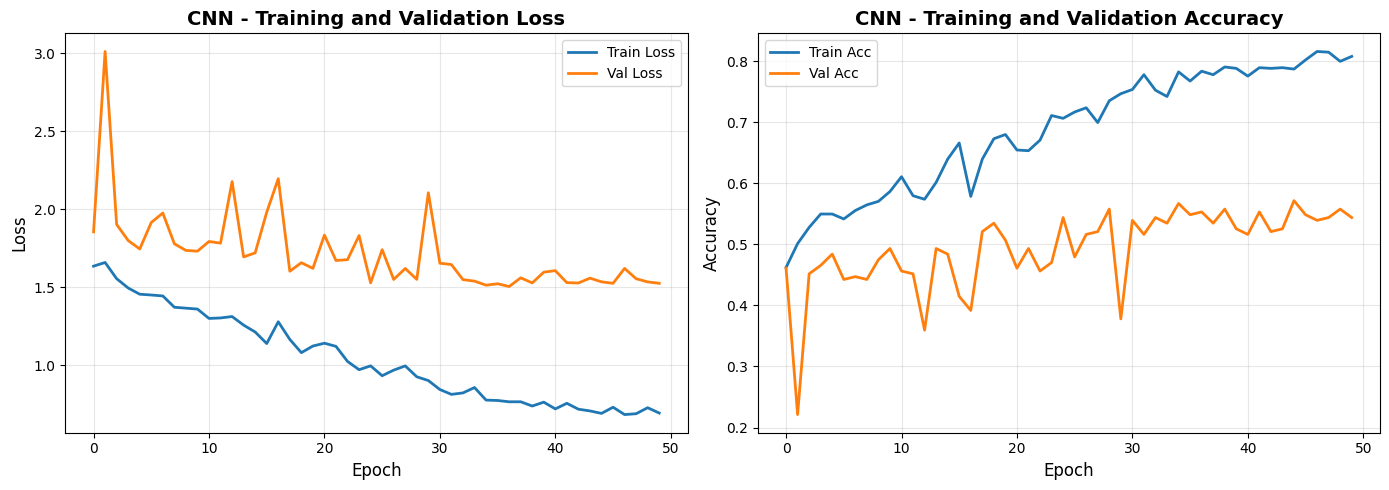

In [20]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title(f'{MODEL_TYPE.upper()} - Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Acc', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title(f'{MODEL_TYPE.upper()} - Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 13. Evaluate on Test Set

In [21]:
# Evaluate on test set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"\n{'='*60}")
print(f"{MODEL_TYPE.upper()} Model - Test Results")
print(f"{'='*60}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

Testing: 100%|███████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 20.61it/s]


CNN Model - Test Results
Test Accuracy: 0.5882 (58.82%)


In [22]:
# Classification report - FIXED: use labels parameter to handle missing classes
print("\nClassification Report:")
print("="*60)

# Get all possible labels
all_labels = list(range(len(label_encoder.classes_)))

print(classification_report(
    y_true, 
    y_pred, 
    labels=all_labels,
    target_names=label_encoder.classes_,
    digits=4,
    zero_division=0  # Handle classes with no predictions
))


Classification Report:
                                  precision    recall  f1-score   support

        Atlantic_Spotted_Dolphin     0.5000    0.5556    0.5263         9
                    Bearded_Seal     0.5000    0.5000    0.5000         6
             Beluga,_White_Whale     0.0000    0.0000    0.0000         8
              Bottlenose_Dolphin     0.6667    1.0000    0.8000         4
                   Bowhead_Whale     0.5333    0.8000    0.6400        10
                 Clymene_Dolphin     0.6667    0.6000    0.6316        10
                  Common_Dolphin     0.0909    0.1250    0.1053         8
              False_Killer_Whale     0.6000    0.6667    0.6316         9
              Fin,_Finback_Whale     1.0000    1.0000    1.0000         8
                 Frasers_Dolphin     0.6250    0.7143    0.6667        14
         Grampus,_Rissos_Dolphin     0.6154    0.7273    0.6667        11
                       Harp_Seal     0.5556    0.6250    0.5882         8
             

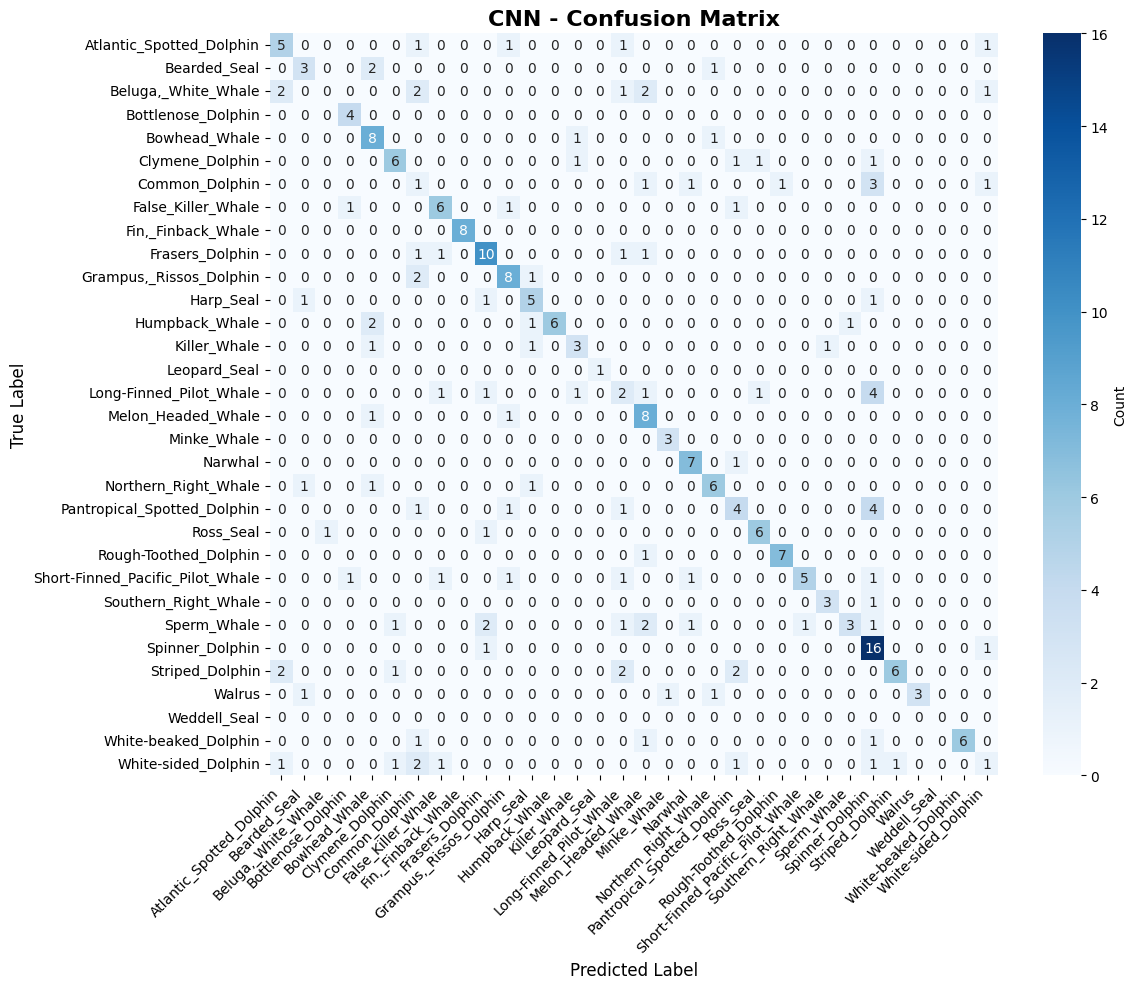

In [23]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=all_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title(f'{MODEL_TYPE.upper()} - Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 14. Train All Models for Comparison

In [24]:
def train_and_evaluate_model(model_type, num_classes, input_height, train_loader, 
                              val_loader, test_loader, device, epochs=EPOCHS):
    """
    Train and evaluate a specific model type
    """
    print(f"\n{'#'*60}")
    print(f"# Training {model_type.upper()} Model")
    print(f"{'#'*60}")
    
    # Create model
    if model_type == 'cnn':
        model = WhaleCNN(num_classes, input_height).to(device)
    elif model_type == 'lstm':
        model = WhaleLSTM(num_classes, input_size=input_height).to(device)
    elif model_type == 'transformer':
        model = WhaleTransformer(num_classes, input_size=input_height).to(device)
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    # Setup training
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # Train
    model, history = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler,
        device, epochs, f'whale_{model_type}'
    )
    
    # Evaluate
    model.eval()
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    test_acc = accuracy_score(y_true, y_pred)
    print(f"\n{model_type.upper()} Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
    
    return {
        'model': model,
        'history': history,
        'test_acc': test_acc,
        'params': total_params
    }

In [25]:
# Uncomment to train all models and compare
# WARNING: This will take a long time!

# results = {}
# for model_type in ['cnn', 'lstm', 'transformer']:
#     results[model_type] = train_and_evaluate_model(
#         model_type, num_classes, input_height,
#         train_loader, val_loader, test_loader, device, epochs=30
#     )

# # Compare results
# print("\n" + "="*60)
# print("MODEL COMPARISON")
# print("="*60)
# for model_type, res in results.items():
#     print(f"{model_type.upper():12s} | Acc: {res['test_acc']:.4f} | Params: {res['params']:,}")

## 15. Save Model and Artifacts

In [ ]:
# Save the trained model
torch.save(model.state_dict(), f'{model_name}_classifier.pth')
print(f"Model saved to '{model_name}_classifier.pth'")

# Save complete model (architecture + weights)
torch.save(model, f'{model_name}_classifier_full.pth')
print(f"Full model saved to '{model_name}_classifier_full.pth'")

# Save label encoder
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("Label encoder saved to 'label_encoder.pkl'")

# Save training history
history_df = pd.DataFrame(history)
history_df.to_csv(f'{model_name}_training_history.csv', index=False)
print(f"Training history saved to '{model_name}_training_history.csv'")

print("\nAll artifacts saved successfully!")

## 16. Make Predictions on New Audio

In [ ]:
def predict_audio(audio_path, model, label_encoder, device):
    """
    Predict class for a single audio file
    
    Args:
        audio_path: Path to audio file
        model: Trained model
        label_encoder: Label encoder
        device: torch device
        
    Returns:
        predicted_class: Predicted class name
        probabilities: Probability distribution
        confidence: Confidence score
    """
    model.eval()
    
    # Convert to spectrogram
    spec = audio_to_spectrogram(audio_path)
    
    if spec is None:
        return None, None, None
    
    # Add batch and channel dimensions
    spec = torch.FloatTensor(spec[np.newaxis, np.newaxis, :, :]).to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(spec)
        probabilities = F.softmax(outputs, dim=1).cpu().numpy()[0]
    
    predicted_idx = np.argmax(probabilities)
    predicted_class = label_encoder.inverse_transform([predicted_idx])[0]
    confidence = probabilities[predicted_idx]
    
    return predicted_class, probabilities, confidence

print("Prediction function defined!")

In [ ]:
# Example: Predict on a random test sample
test_idx = np.random.randint(0, len(X_test))
test_sample = torch.FloatTensor(X_test[test_idx:test_idx+1]).to(device)
true_label = label_encoder.inverse_transform([y_test[test_idx]])[0]

# Make prediction
model.eval()
with torch.no_grad():
    outputs = model(test_sample)
    pred_proba = F.softmax(outputs, dim=1).cpu().numpy()[0]

pred_idx = np.argmax(pred_proba)
pred_label = label_encoder.inverse_transform([pred_idx])[0]
confidence = pred_proba[pred_idx]

# Display results
print(f"{'='*60}")
print("SAMPLE PREDICTION")
print(f"{'='*60}")
print(f"True Label: {true_label}")
print(f"Predicted Label: {pred_label}")
print(f"Confidence: {confidence:.4f} ({confidence*100:.2f}%)")
print(f"\nCorrect: {'Yes' if true_label == pred_label else 'No'}")

# Visualize the spectrogram
plt.figure(figsize=(12, 4))
plt.imshow(X_test[test_idx, 0], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Normalized Amplitude')
plt.title(f'Spectrogram - True: {true_label}, Predicted: {pred_label}', fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## 17. Summary

In [ ]:
print("="*60)
print("WHALE AUDIO CLASSIFICATION - SUMMARY")
print("="*60)
print(f"\nDataset:")
print(f"  Total samples: {len(X)}")
print(f"  Number of classes: {num_classes}")
print(f"\nSpectrogram Processing:")
print(f"  Method: scipy.signal.spectrogram")
print(f"  FFT size: {N_FFT}")
print(f"  Hop length: {HOP_LENGTH}")
print(f"  Frequency bins: {N_FREQ_BINS}")
print(f"\nModel: {MODEL_TYPE.upper()}")
print(f"  Input shape: {X_train.shape[1:]}")
print(f"  Parameters: {total_params:,}")
print(f"\nPerformance:")
print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"\nAvailable Models:")
print(f"  - CNN (WhaleCNN)")
print(f"  - LSTM (WhaleLSTM) with attention")
print(f"  - Transformer (WhaleTransformer) with CLS token")
print("="*60)
print("\nTraining Complete!")